# Micrograd
A tiny autograd engine. Implements backpropagation over a dynamically built DAG and a small nn library on top of it with a PyTorch-like API. The DAG only operates over scalar values, so each neuron is chopped up into individual small additions and multiplications.

In [139]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
def f(x):
    return 3*x**2 - 4 * x + 5

In [141]:
f(3.0)

20.0

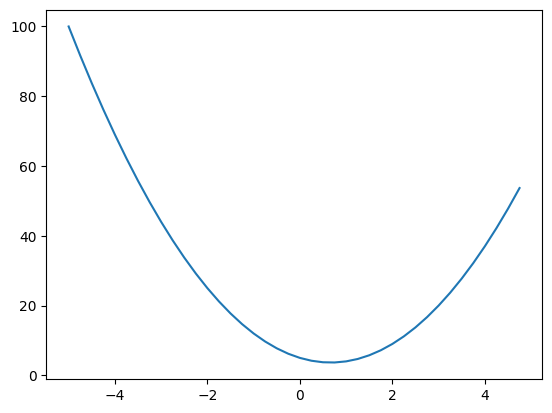

In [142]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

In [143]:
h = .000000000001
x = 2/3
(f(x + h) - f(x)) / h

-0.0004440892098500626

In [144]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [145]:
h = .0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [146]:
class Value:
    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = math.exp(x) * out.grad

        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return -1 * self

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad = other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) -1 ) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2 ) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def top_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    top_sort(child)
                topo.append(v)
        top_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'


In [147]:
a = Value(3.0, label='a')
b = Value(2.0, label = 'b')
a / b

Value(data=1.5)

In [148]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

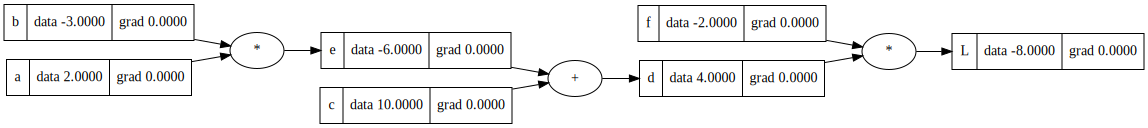

In [149]:
draw_dot(L)

In [150]:
L.grad = 1.0; f.grad = 4.0; d.grad = -2.0; c.grad = -2.0; e.grad = -2.0
b.grad = -4.0; a.grad = 6.0

In [151]:
def experiment():
    h = 0.0001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)
experiment()

6.000000000021544


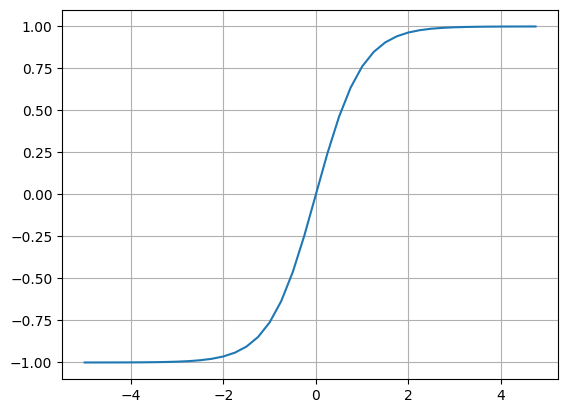

In [152]:
plt.plot(np.arange(-5, 5, .25), np.tanh(np.arange(-5, 5, .25))); plt.grid()

In [153]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')

# calculations
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

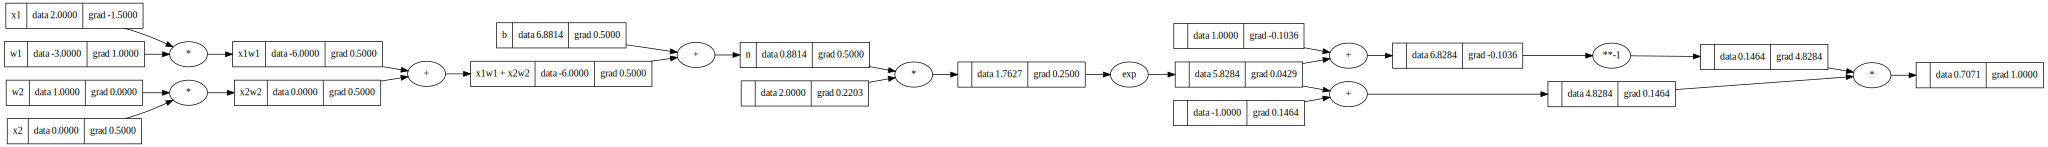

In [154]:
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)

In [155]:
"""topo = []
visited = set()
def top_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            top_sort(child)
        topo.append(v)
top_sort(o)
for node in reversed(topo):
    node._backward()"""
o.backward()

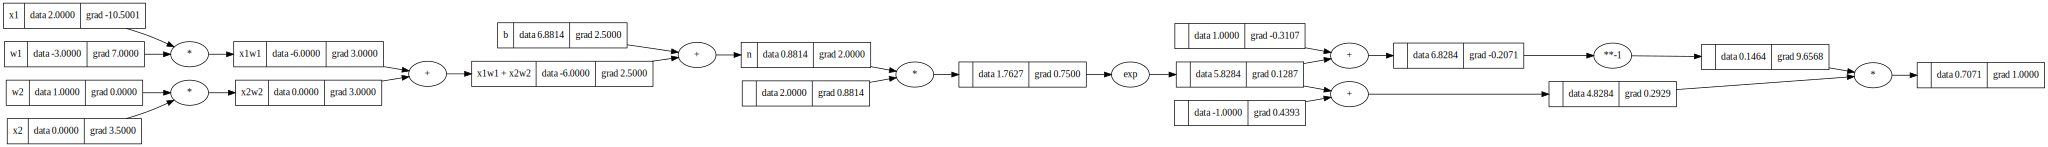

In [156]:
draw_dot(o)

In [157]:
import torch

In [158]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([3.0]).double() ; x2.requires_grad = True
b = torch.Tensor([5.0]).double(); b.requires_grad = True
x1x2 = x1 * x2 + b
o = x1x2.sigmoid()
print(o.data.item())
o.backward()

print('----')
print(f'x1 grad: {x1.grad.item()}')

0.999983298578152
----
x1 grad: 5.010342873138471e-05


In [159]:
class Neuron:
    def __init__(self, nin):
        self.w = (Value(random.uniform(-1, 1)) for _ in range(nin))
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x))) + self.b
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.Neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.Neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

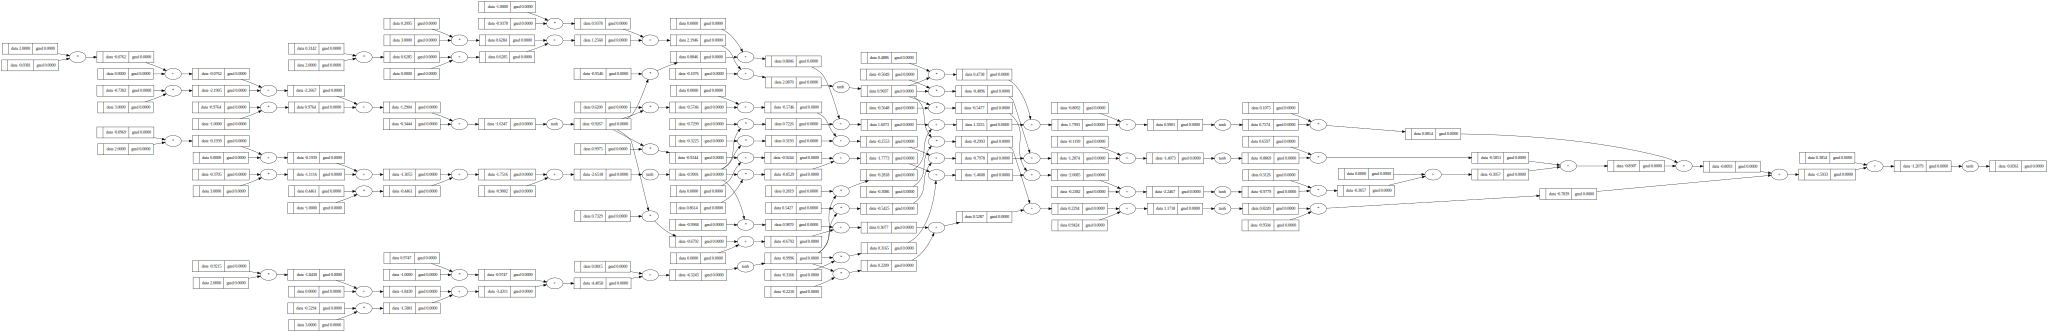

In [160]:
draw_dot(n(x))

In [161]:
mlp = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.9345706549102005),
 Value(data=0.5077022554593371),
 Value(data=0.5077022554593371),
 Value(data=0.5077022554593371)]